In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nagachandana","key":"b58c9aed98bd46b0ff0a906eb583645b"}'}

In [2]:
# create a kaggle folder
!mkdir -p ~/.kaggle

In [3]:
#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download kinguistics/heartbeat-sounds

Dataset URL: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds
License(s): CC0-1.0
 91% 100M/110M [00:01<00:00, 88.3MB/s] 
100% 110M/110M [00:01<00:00, 65.2MB/s]


In [6]:
!unzip heartbeat-sounds.zip -d ./heartbeat-sounds


Archive:  heartbeat-sounds.zip
  inflating: ./heartbeat-sounds/set_a.csv  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201012172010.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101051105.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101061552.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101091156.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101110659.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101152256.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101220549.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201101241434.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201102081033.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201102081045.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201102200848.wav  
  inflating: ./heartbeat-sounds/set_a/Aunlabelledtest__201103011036.wav  
  inflating: ./heartbeat-sounds/set_a

In [7]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [8]:
# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.15.0
keras version:  3.4.1


In [9]:
# parent folder of sound files
INPUT_DIR="/content/heartbeat-sounds"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12

In [10]:
!pwd
!ls -all "/content/heartbeat-sounds"

/content
total 144
drwxr-xr-x 4 root root  4096 Jul 10 23:35 .
drwxr-xr-x 1 root root  4096 Jul 10 23:35 ..
drwxr-xr-x 2 root root 12288 Jul 10 23:35 set_a
-rw-r--r-- 1 root root  7031 Sep 20  2019 set_a.csv
-rw-r--r-- 1 root root 17115 Sep 20  2019 set_a_timing.csv
drwxr-xr-x 2 root root 49152 Jul 10 23:35 set_b
-rw-r--r-- 1 root root 42145 Sep 20  2019 set_b.csv


In [11]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [12]:
set_a_timing=pd.read_csv(INPUT_DIR+"/set_a_timing.csv")
set_a_timing.head()

fname  cycle sound  location
0  set_a/normal__201102081321.wav      1    S1     10021
1  set_a/normal__201102081321.wav      1    S2     20759
2  set_a/normal__201102081321.wav      2    S1     35075
3  set_a/normal__201102081321.wav      2    S2     47244
4  set_a/normal__201102081321.wav      3    S1     62992

In [13]:
import pandas as pd

set_a = pd.read_csv('/content/heartbeat-sounds/set_a.csv')
set_b = pd.read_csv('/content/heartbeat-sounds/set_b.csv')

In [14]:
#merge both set-a and set-b
frames = [set_a, set_b]
train_ab=pd.concat(frames)
train_ab.describe()

dataset                             fname   label     sublabel
count      832                               832     585          149
unique       2                               832       5            2
top          b  set_a/artifact__201012172012.wav  normal  noisynormal
freq       656                                 1     351          120

In [15]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


Min samples per category =  19
Max samples per category =  351


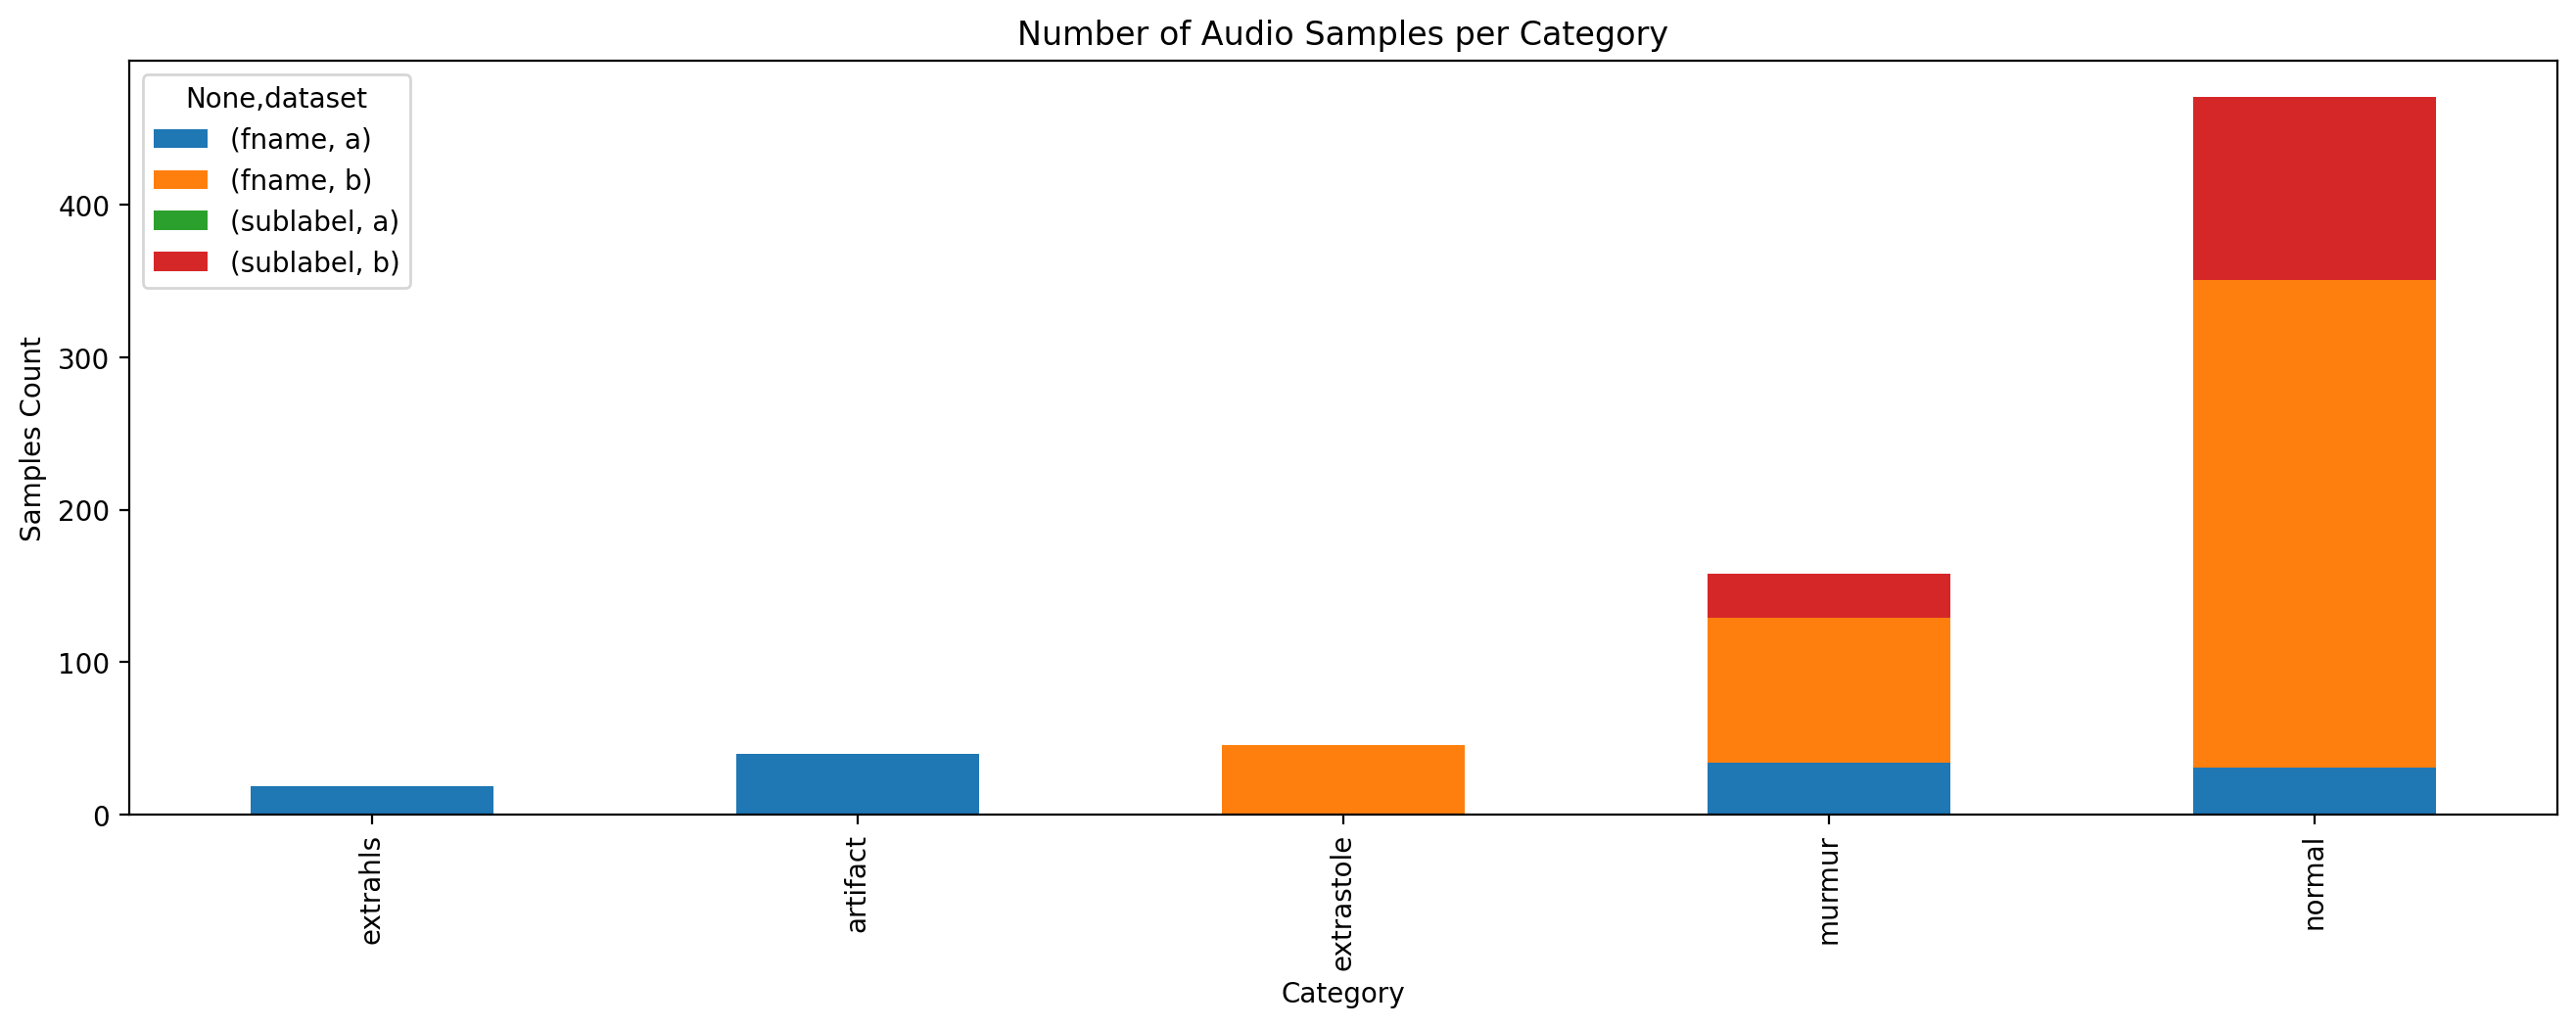

In [16]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [17]:
print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

Minimum samples per category =  19
Maximum samples per category =  351


In [18]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [19]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file)

In [20]:
# Load use wave
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [21]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


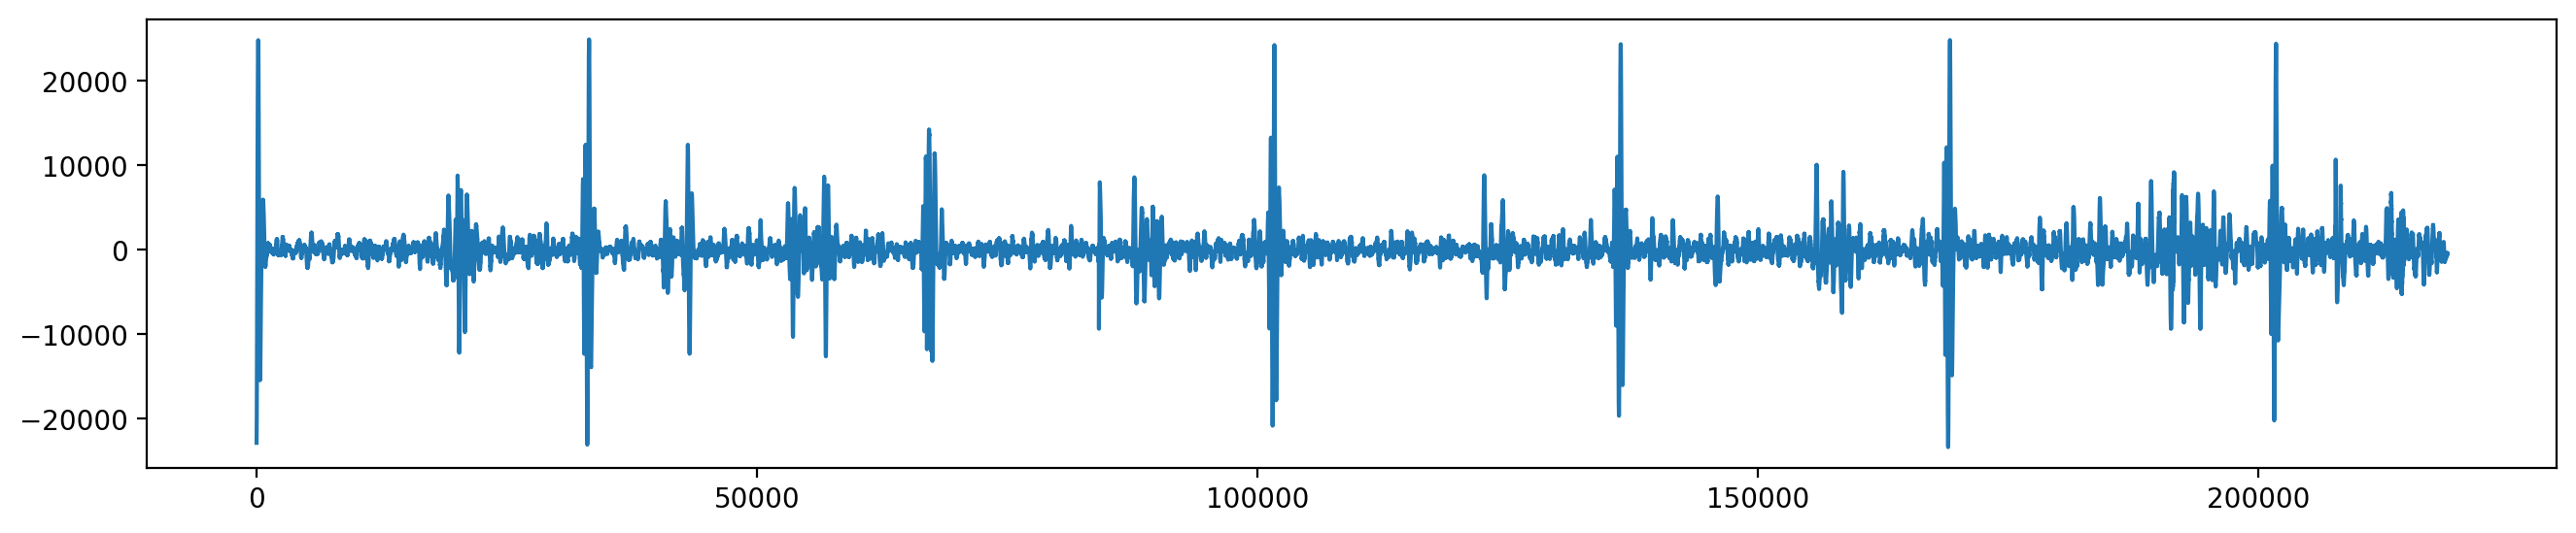

In [22]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [23]:
import librosa

# Load the audio file
y, sr = librosa.load(normal_file, duration=5)   # default sampling rate is 22050 Hz

# Get the duration of the audio signal
dur = librosa.get_duration(y=y, sr=sr)
print("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


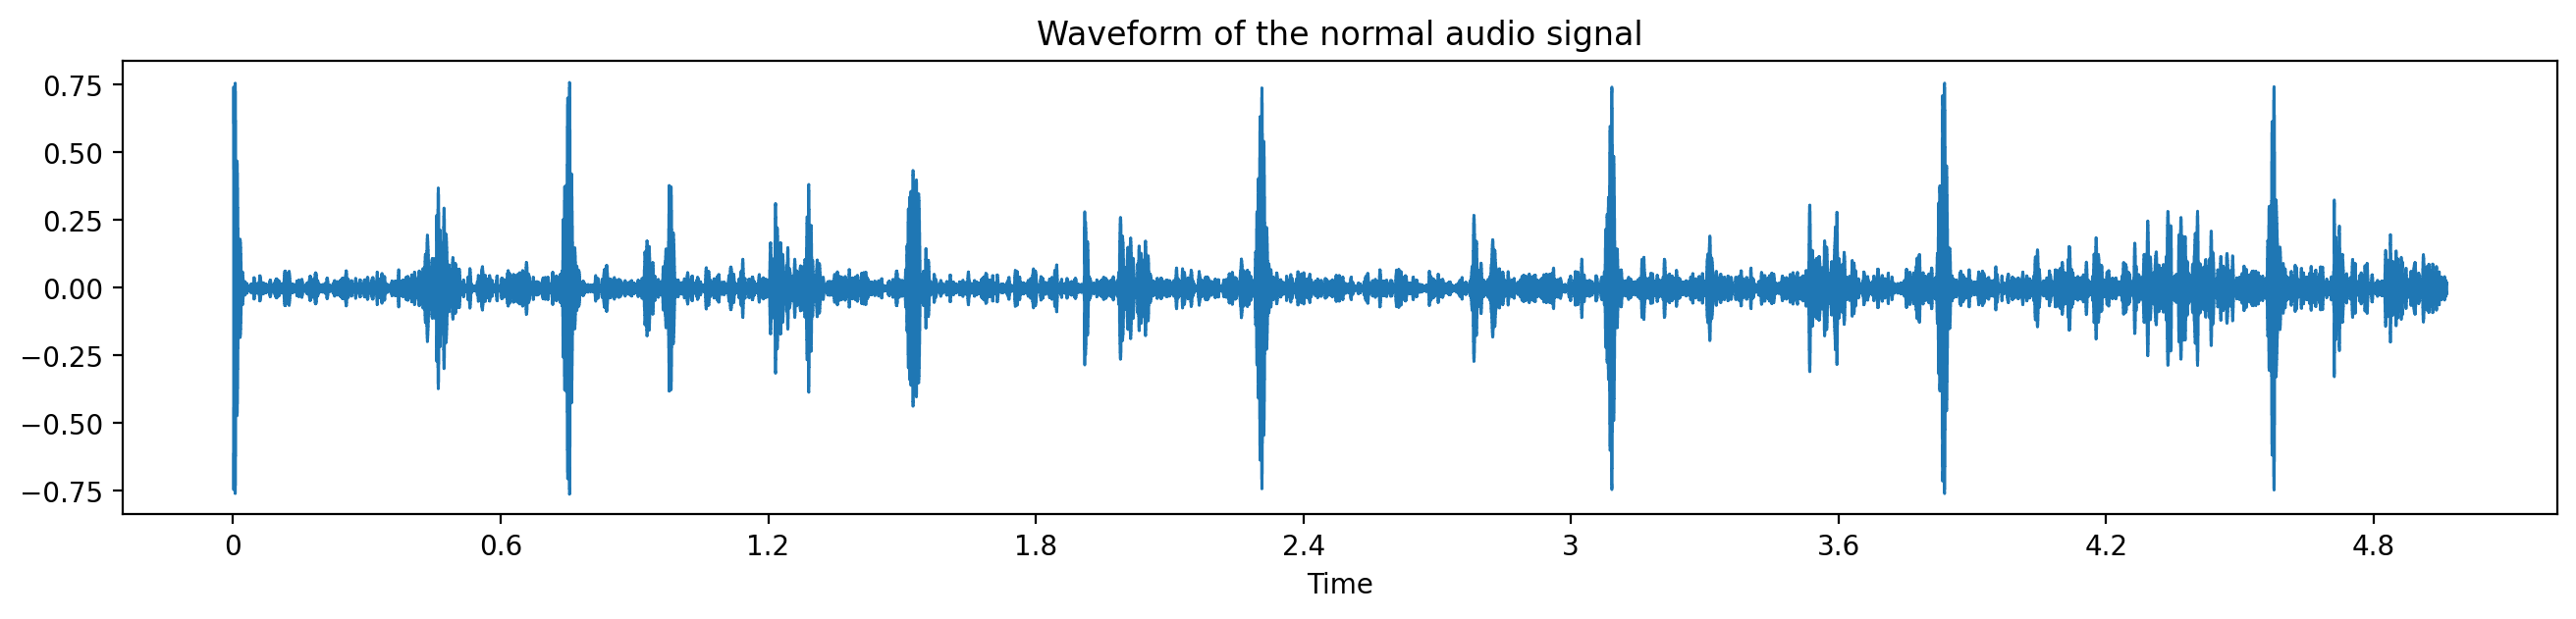

In [24]:
# Plot the normal waveform
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of the normal audio signal')
plt.show()

In [25]:
# Define the path to the murmur case audio file
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"  # Adjust the path to your file

# Load the audio file
y2, sr2 = librosa.load(murmur_file, duration=5)

# Get the duration of the murmur audio signal
dur = librosa.get_duration(y=y2, sr=sr2)
print("duration:", dur)
print(y2.shape, sr2)


duration: 5.0
(110250,) 22050


In [26]:
# heart it
import IPython.display as ipd
ipd.Audio(murmur_file)

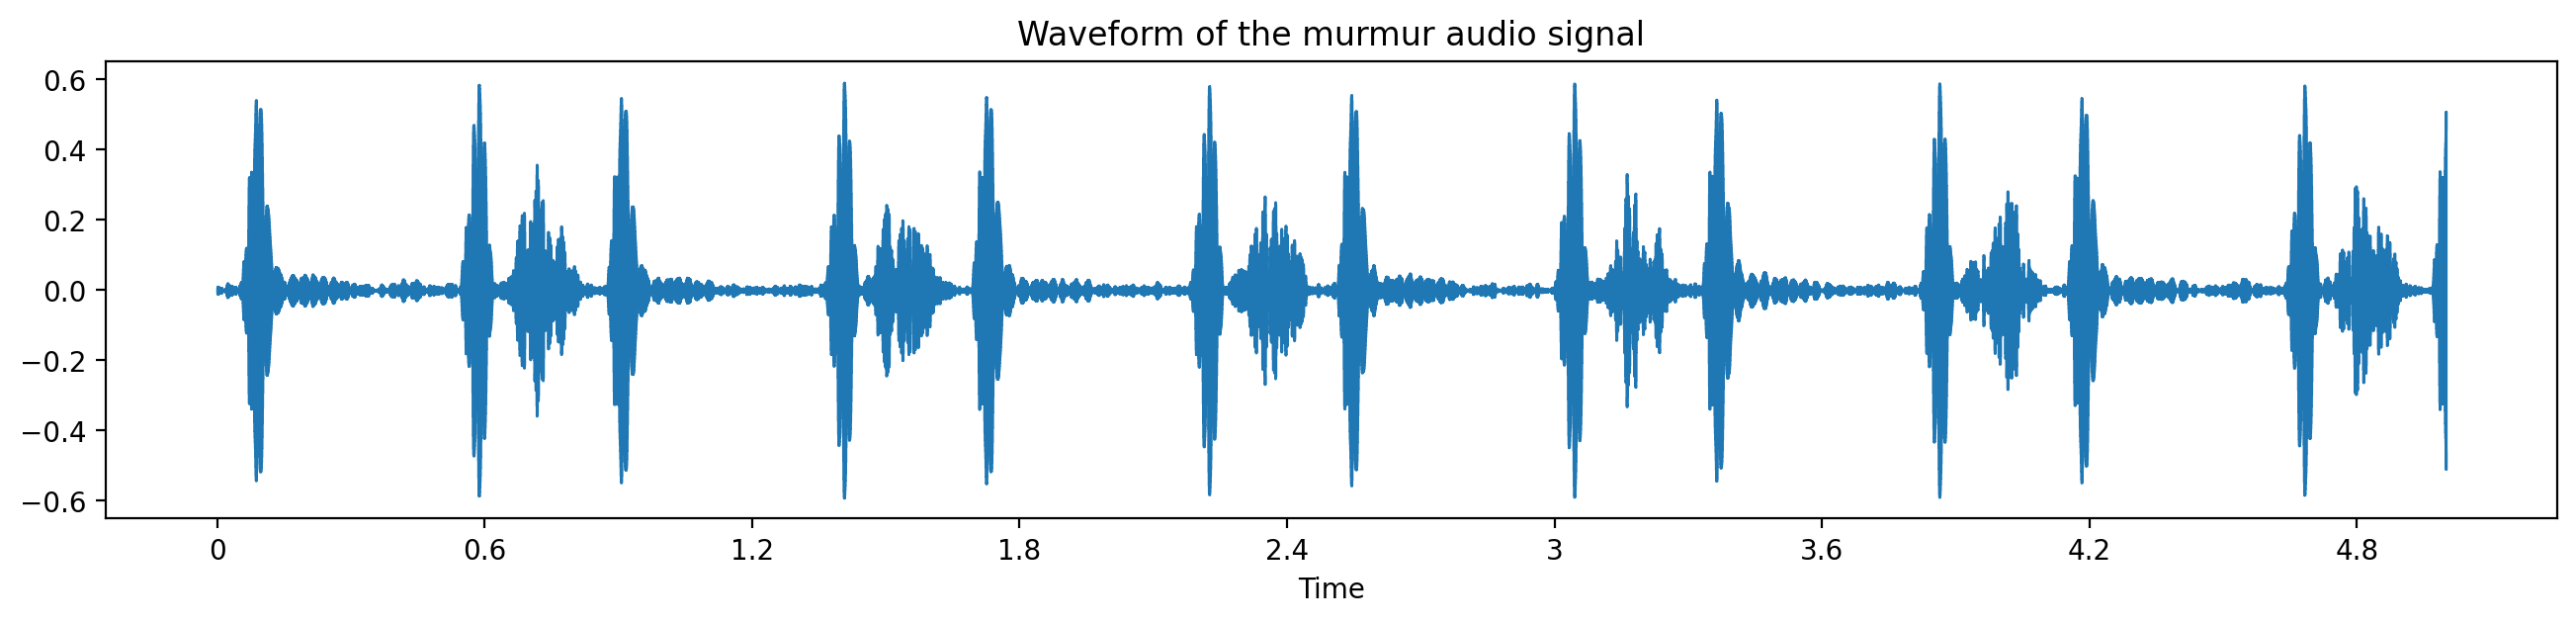

In [27]:
# Plot the murmur waveform
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y=y2, sr=sr2)
plt.title('Waveform of the murmur audio signal')
plt.show()

In [28]:
# Define the path to the murmur case audio file
extrastole_file=INPUT_DIR+"/set_b/extrastole__127_1306764300147_C2.wav"

# Load the audio file
y3, sr3 = librosa.load(extrastole_file, duration=5)

# Get the duration of the extrastole audio signal
dur = librosa.get_duration(y=y3, sr=sr3)
print("duration:", dur)
print(y2.shape, sr3)

duration: 4.676009070294785
(110250,) 22050


In [29]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file)

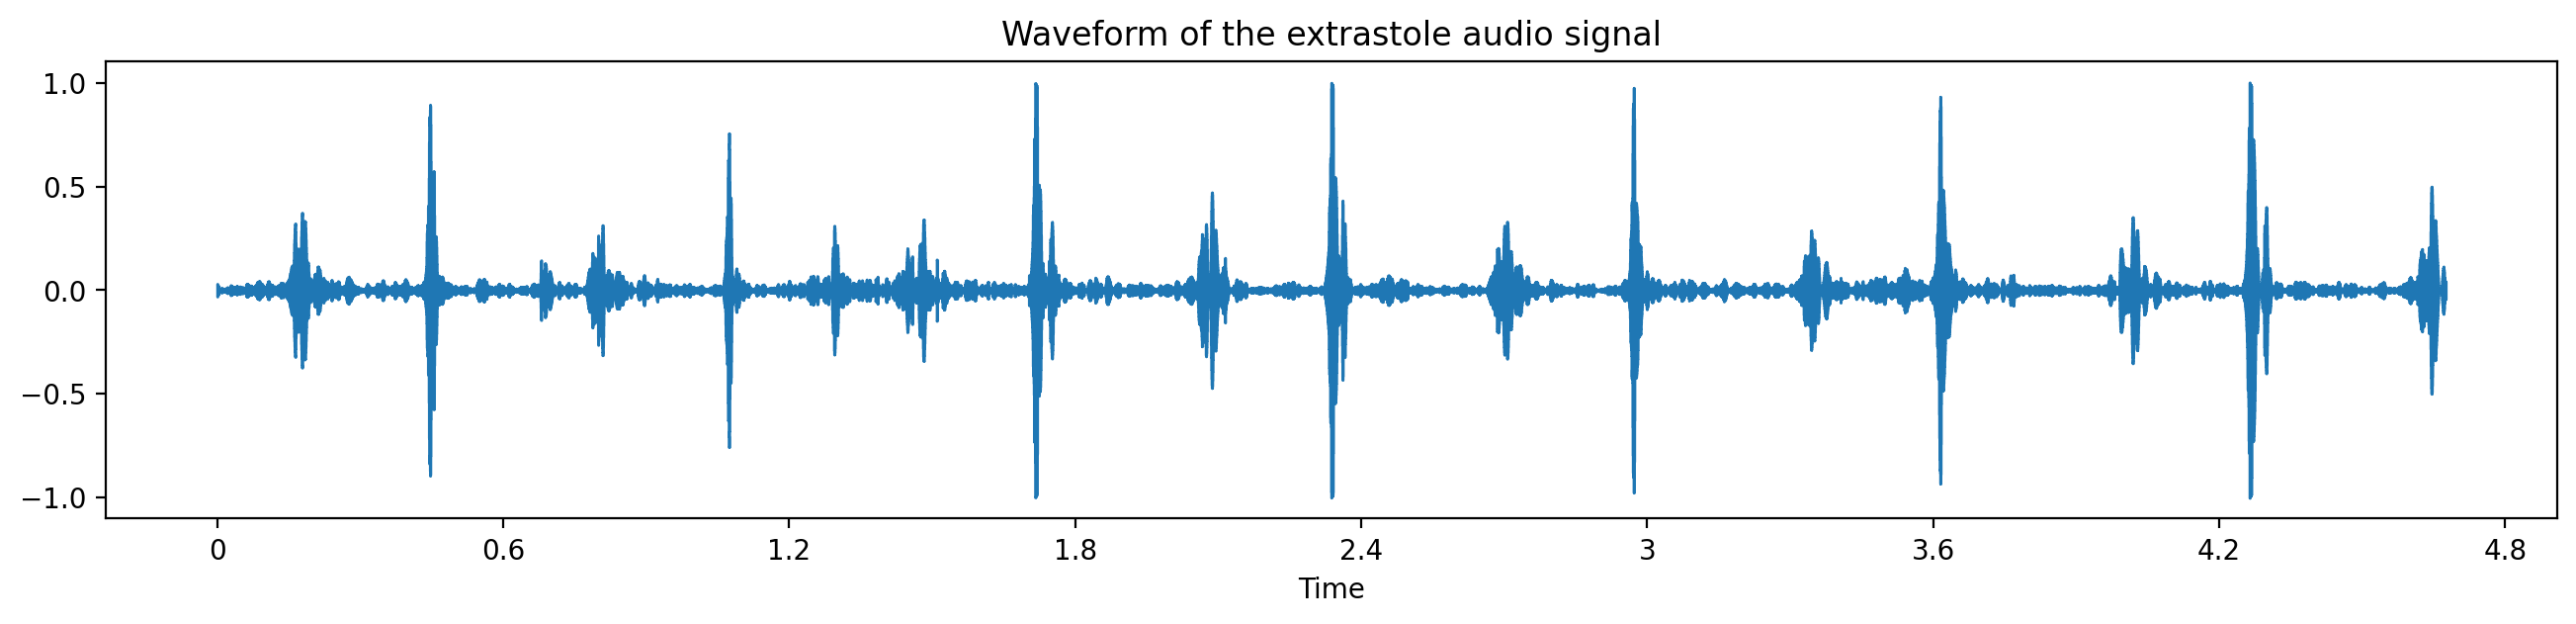

In [30]:
# Plot the extrastole waveform
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y=y3, sr=sr)
plt.title('Waveform of the extrastole audio signal')
plt.show()

In [31]:
# Define the path for artifact file
artifact_file=INPUT_DIR+"/set_a/artifact__201012172012.wav"

# Load the audio file
y4, sr4 = librosa.load(artifact_file, duration=5)

# Get the duration of the artifact audio signal
dur=librosa.get_duration(y=y4, sr=sr4)
print ("duration:", dur)
print(y4.shape,sr4)

duration: 5.0
(110250,) 22050


In [32]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file)

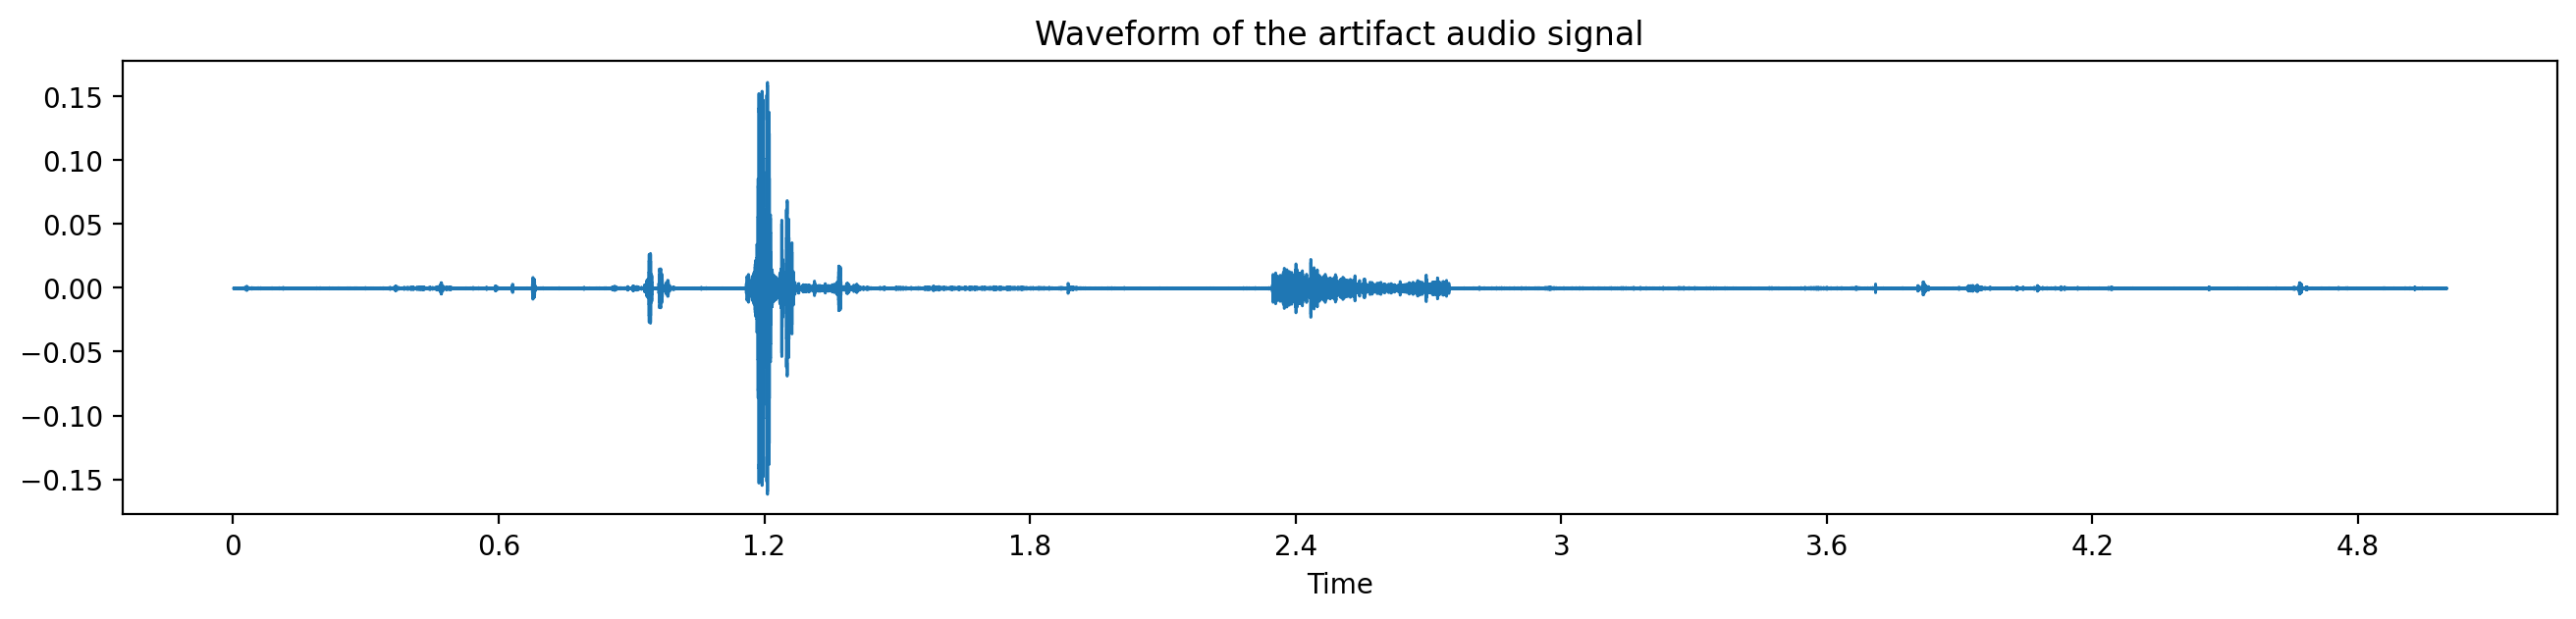

In [33]:
# Plot the artifact waveform
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y=y4, sr=sr4)
plt.title('Waveform of the artifact audio signal')
plt.show()

In [34]:
# Define the path for extrahls sound
extrahls_file=INPUT_DIR+"/set_a/extrahls__201101070953.wav"

#Load the audio file
y5, sr5 = librosa.load(extrahls_file, duration=5)

#Get the duration of the extrahals sound audio signal
dur=librosa.get_duration(y=y5, sr=sr5)
print ("duration:", dur)
print(y5.shape,sr5)

duration: 5.0
(110250,) 22050


In [35]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file)

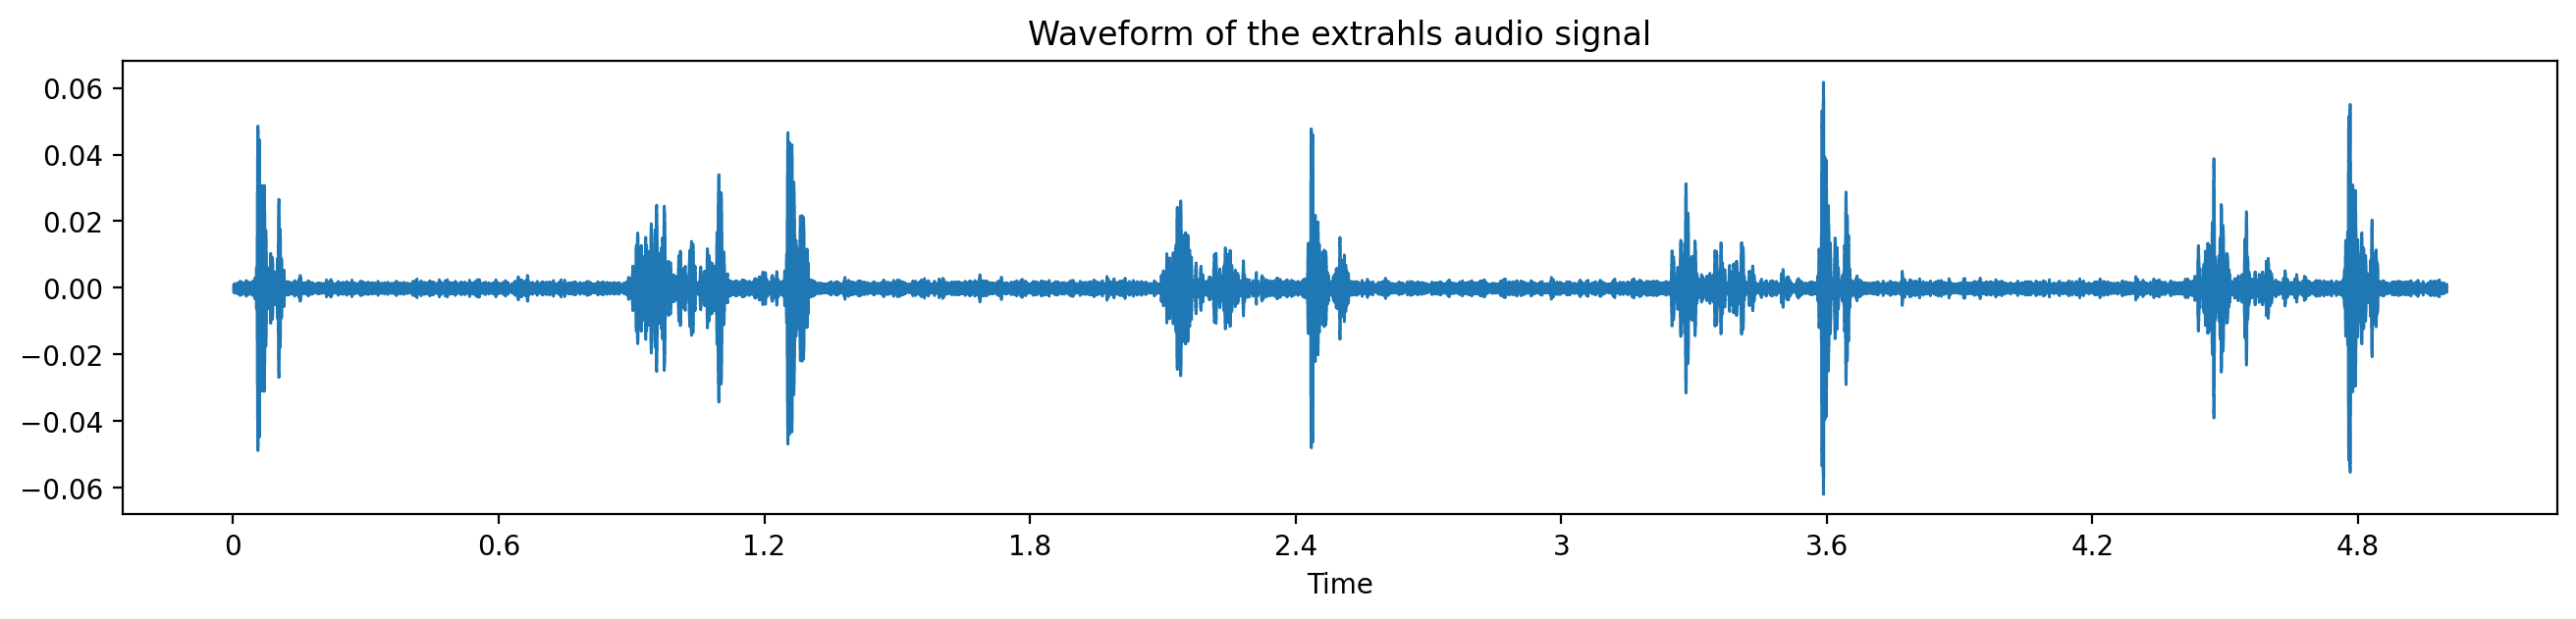

In [36]:
# Plot the artifact waveform
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y=y5, sr=sr5)
plt.title('Waveform of the extrahls audio signal')
plt.show()


In [37]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-8.1913383e+01 -1.4807559e+02 -4.0729141e+02 ... -3.6786765e+02
  -3.7412054e+02 -3.7847031e+02]
 [ 1.2379559e+02  1.2622456e+02  1.3922583e+02 ...  1.5123857e+02
   1.6177921e+02  1.6117076e+02]
 [ 1.7456493e+01  1.9744457e+01  1.9956833e+01 ...  2.9298073e+01
   2.5672840e+01  3.3723251e+01]
 ...
 [-7.1166623e-01 -1.5279193e-01 -1.3570640e+00 ... -2.9591650e-01
   3.5141277e-01  2.2013907e+00]
 [-2.7901702e+00 -2.1342330e+00  4.8860550e-02 ...  2.5581996e+00
   3.4891367e-03  5.4476881e+00]
 [-1.3884640e-01  3.3569953e-01 -2.9419868e+00 ...  2.3936687e+00
  -1.4753845e+00  3.3484596e-01]]


In [38]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.1982685e+01 -1.2800836e+02 -3.9028296e+02 ... -3.5058392e+02
  -3.5407178e+02 -3.5892279e+02]
 [ 1.1376016e+02  1.1646744e+02  1.3576584e+02 ...  1.4986195e+02
   1.5767870e+02  1.5809064e+02]
 [ 2.1968613e+01  2.4365150e+01  1.1875887e+01 ...  2.0178362e+01
   1.8738567e+01  2.7622364e+01]
 ...
 [-1.3763447e+00 -7.9267412e-01 -2.0632429e+00 ...  2.9104049e+00
  -1.4185076e+00  1.5542842e+00]
 [-2.6494288e+00 -2.2966690e+00 -3.4821868e+00 ...  1.3711317e+00
   3.4656078e-02 -1.5800266e+00]
 [-4.1403532e+00 -4.1632409e+00 -1.6855979e+00 ...  4.1955799e-01
   6.4381737e-01 -3.5052755e+00]]


In [39]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

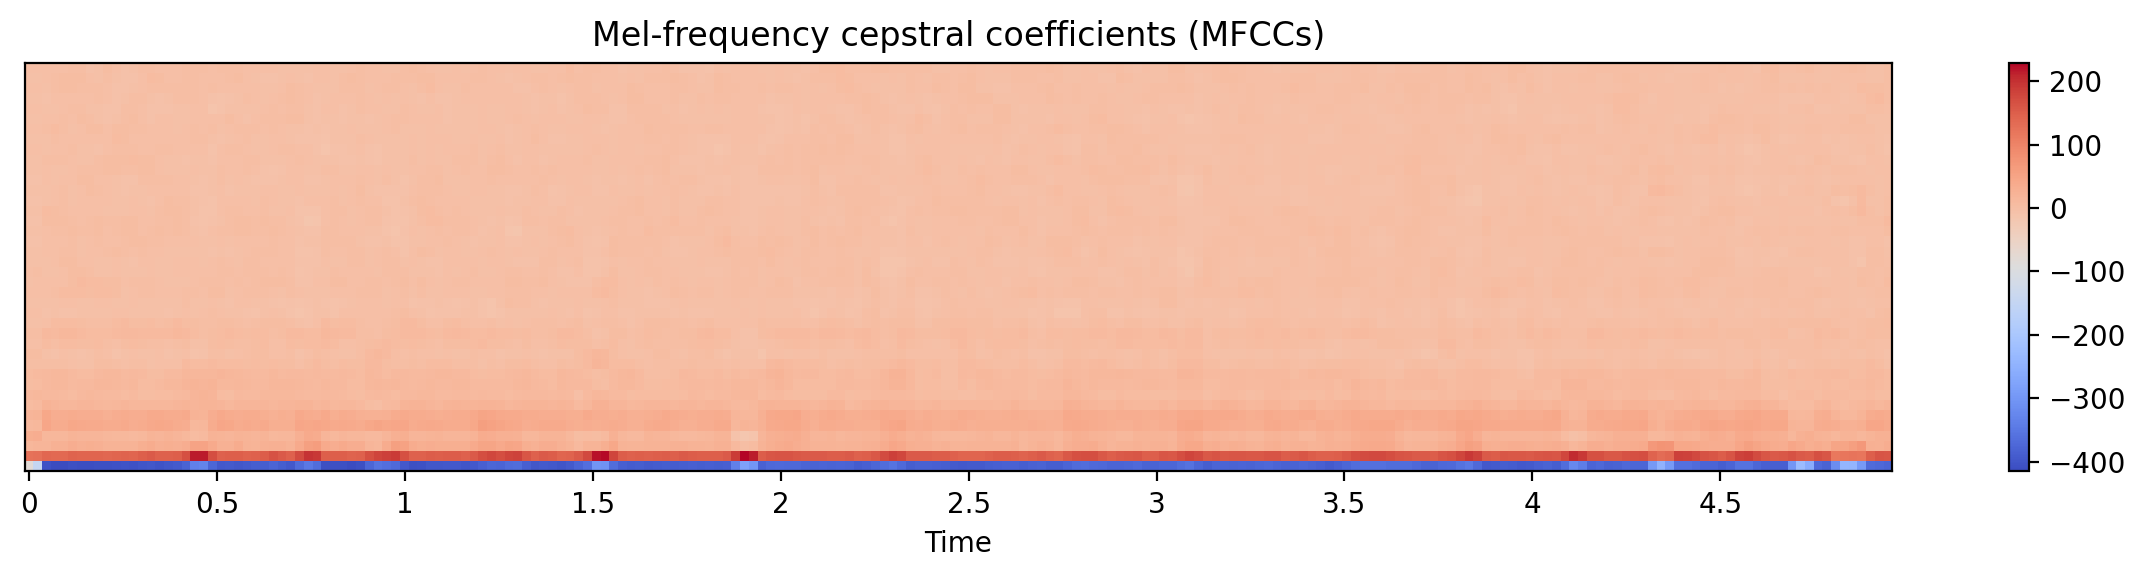

In [40]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

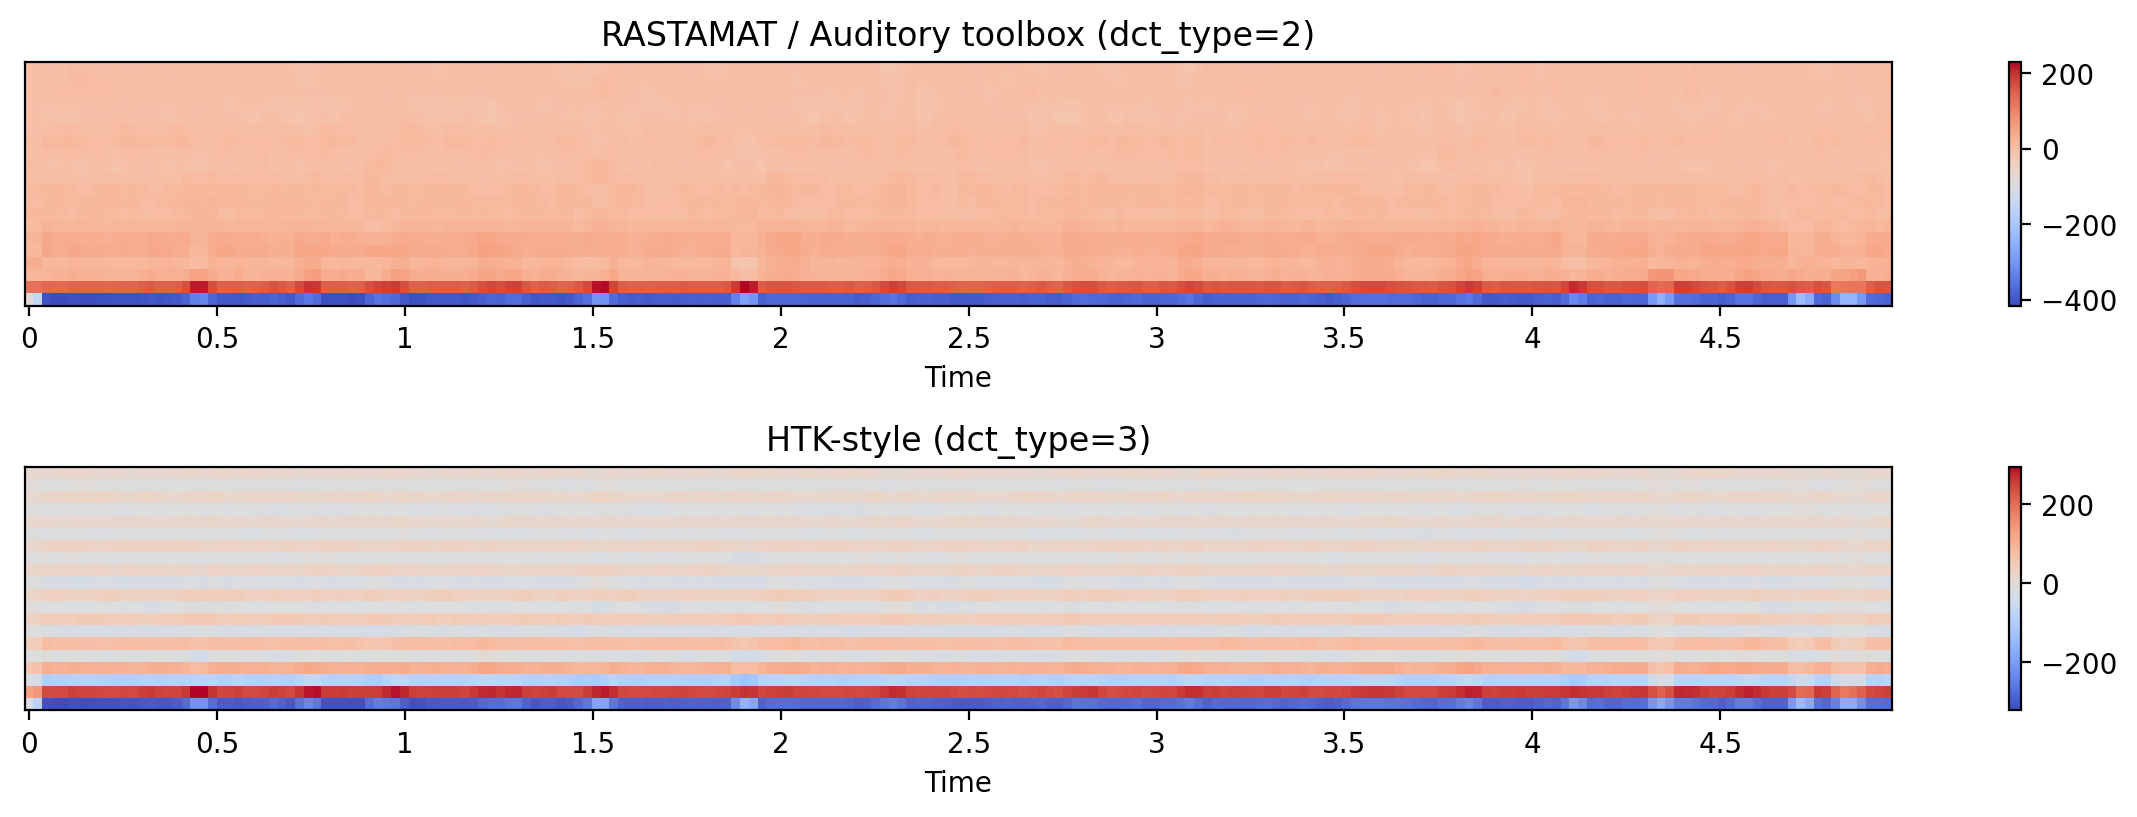

In [41]:
# Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)

#m_dct1 = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
plt.figure(figsize=(12, 6))
#plt.subplot(3, 1, 1)
#librosa.display.specshow(m_dct1, x_axis='time')
#plt.title('Discrete cosine transform (dct_type=1)')
#plt.colorbar()
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.subplot(3, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

In [42]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.80807256,
       3.85451247, 4.13315193, 4.36535147, 4.59755102, 4.73687075,
       4.85297052])

In [43]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

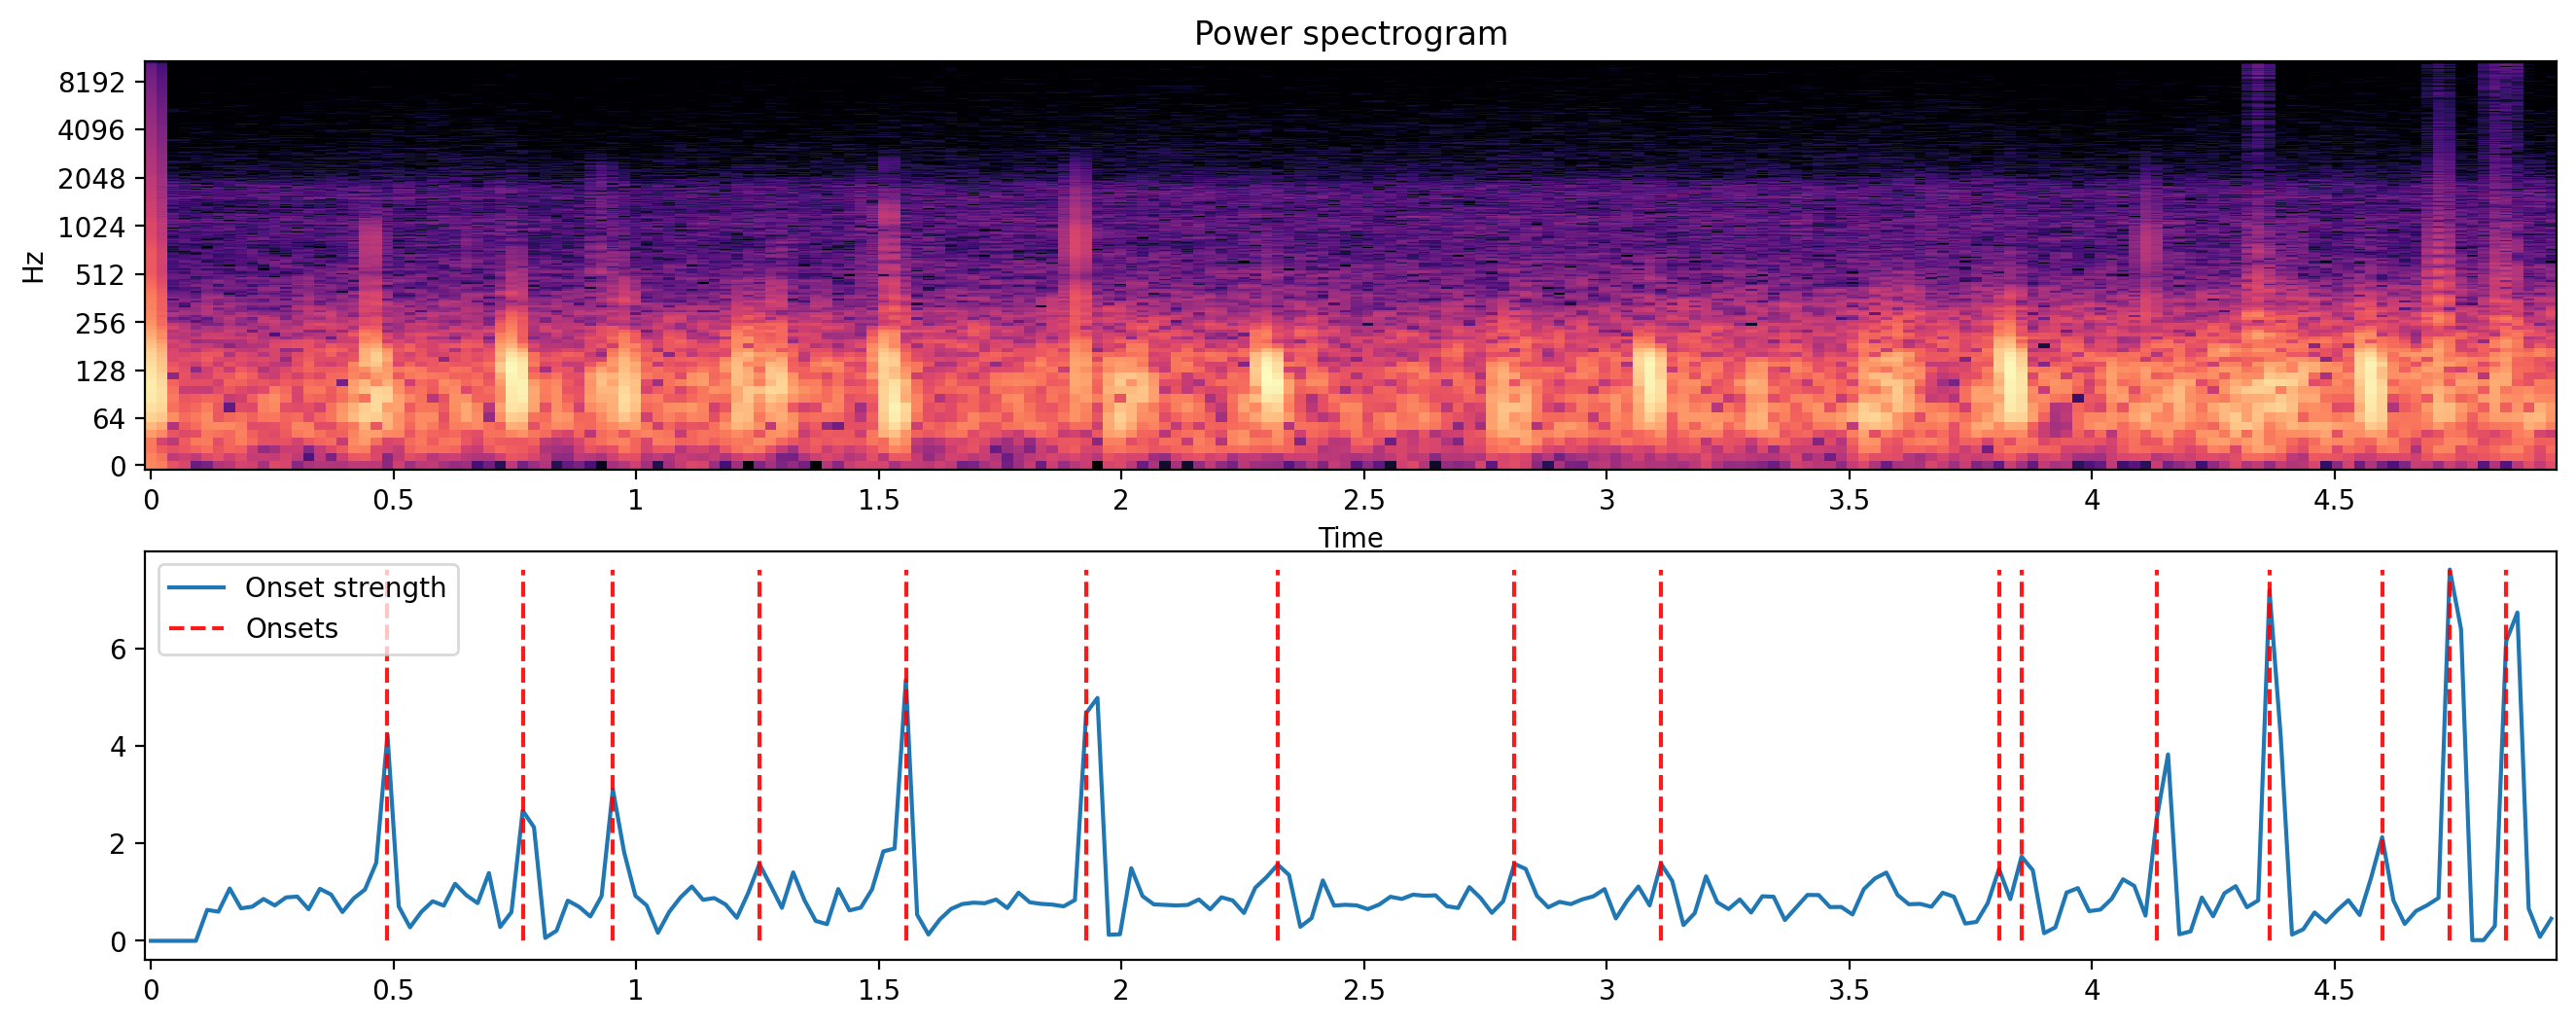

In [44]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

In [45]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

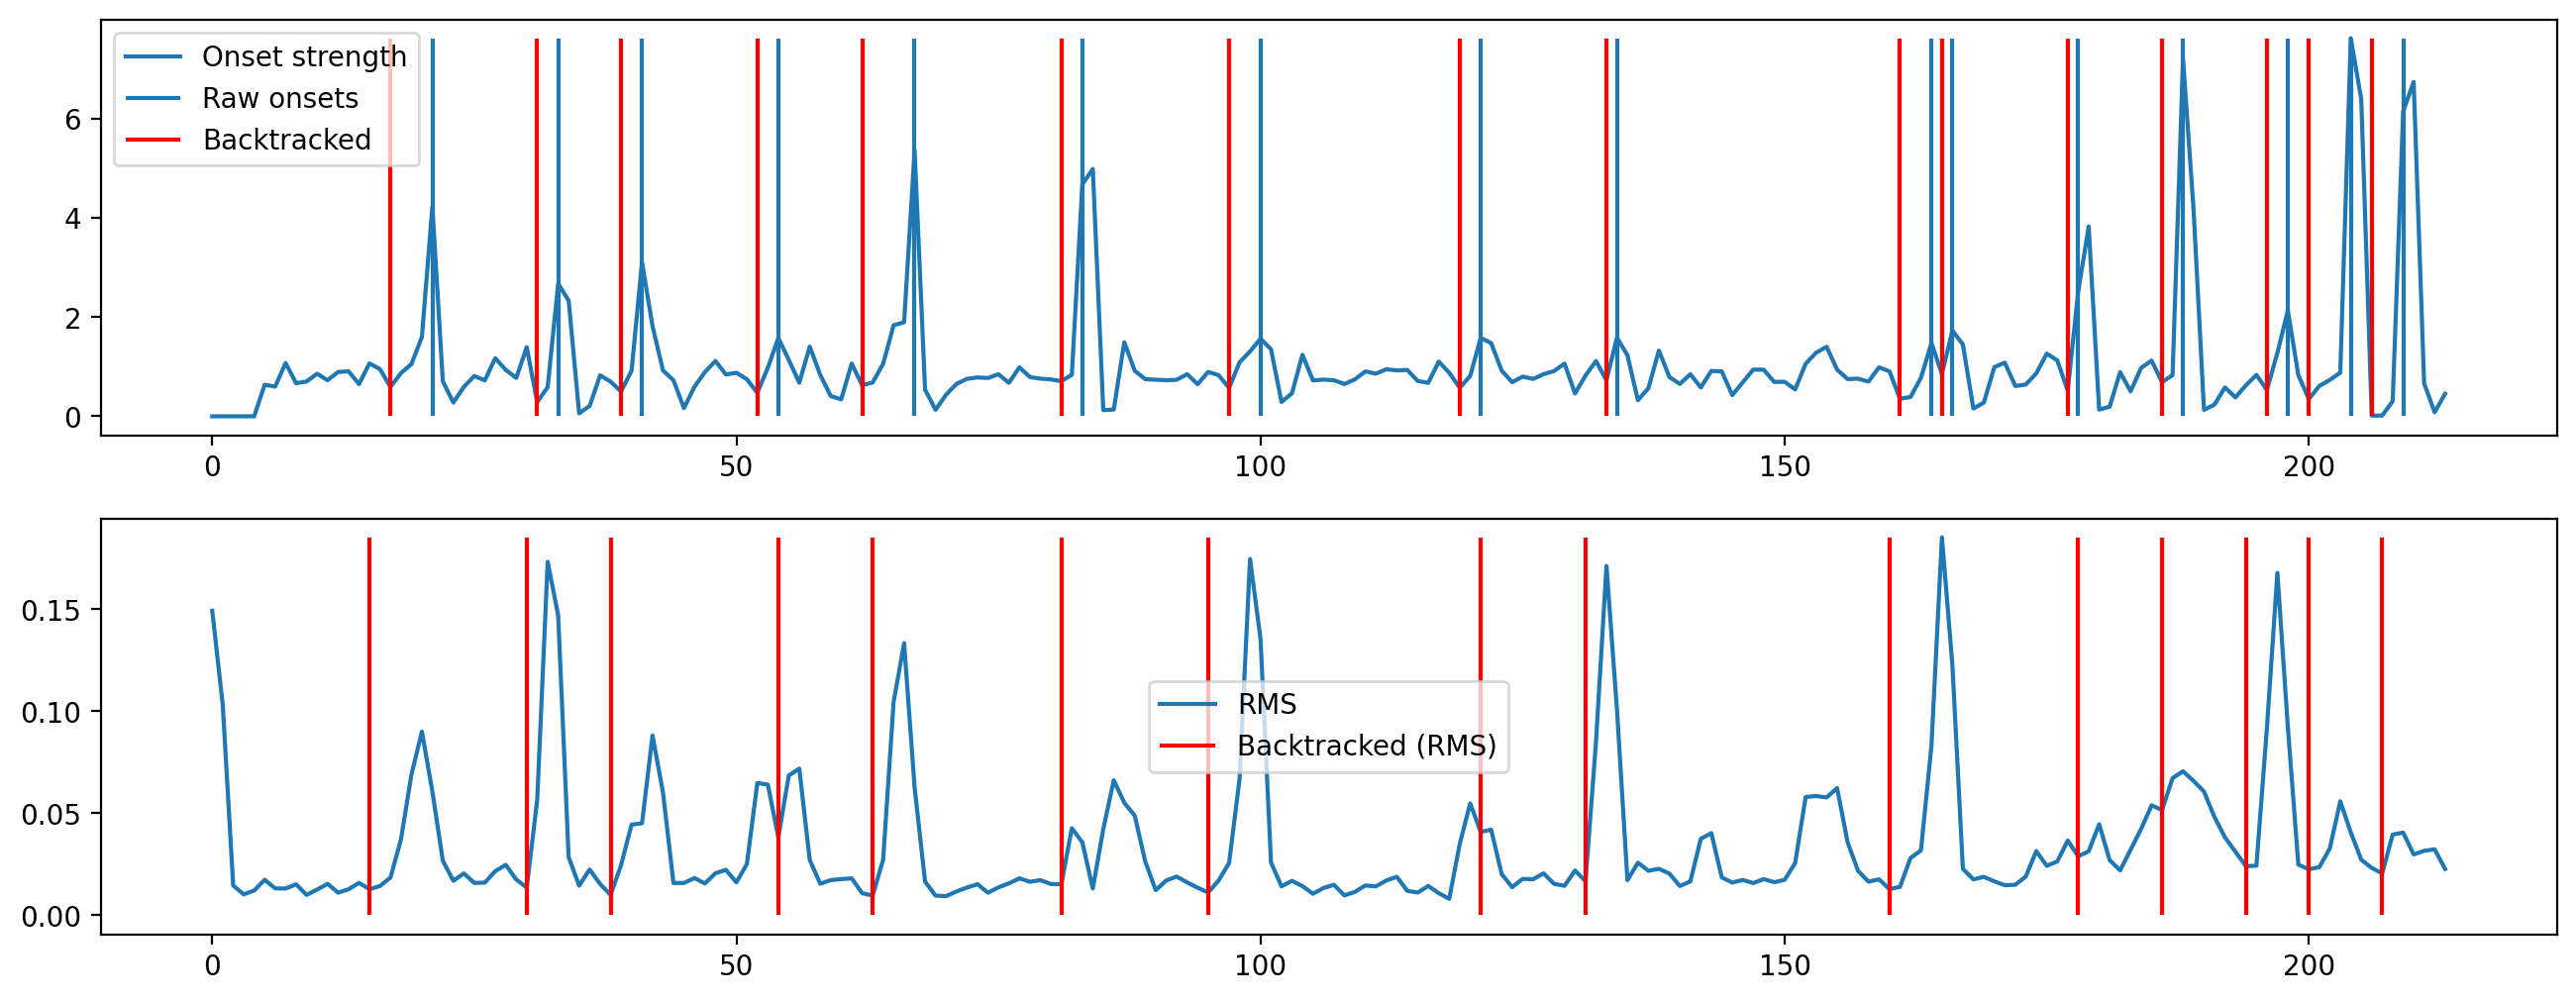

In [46]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)

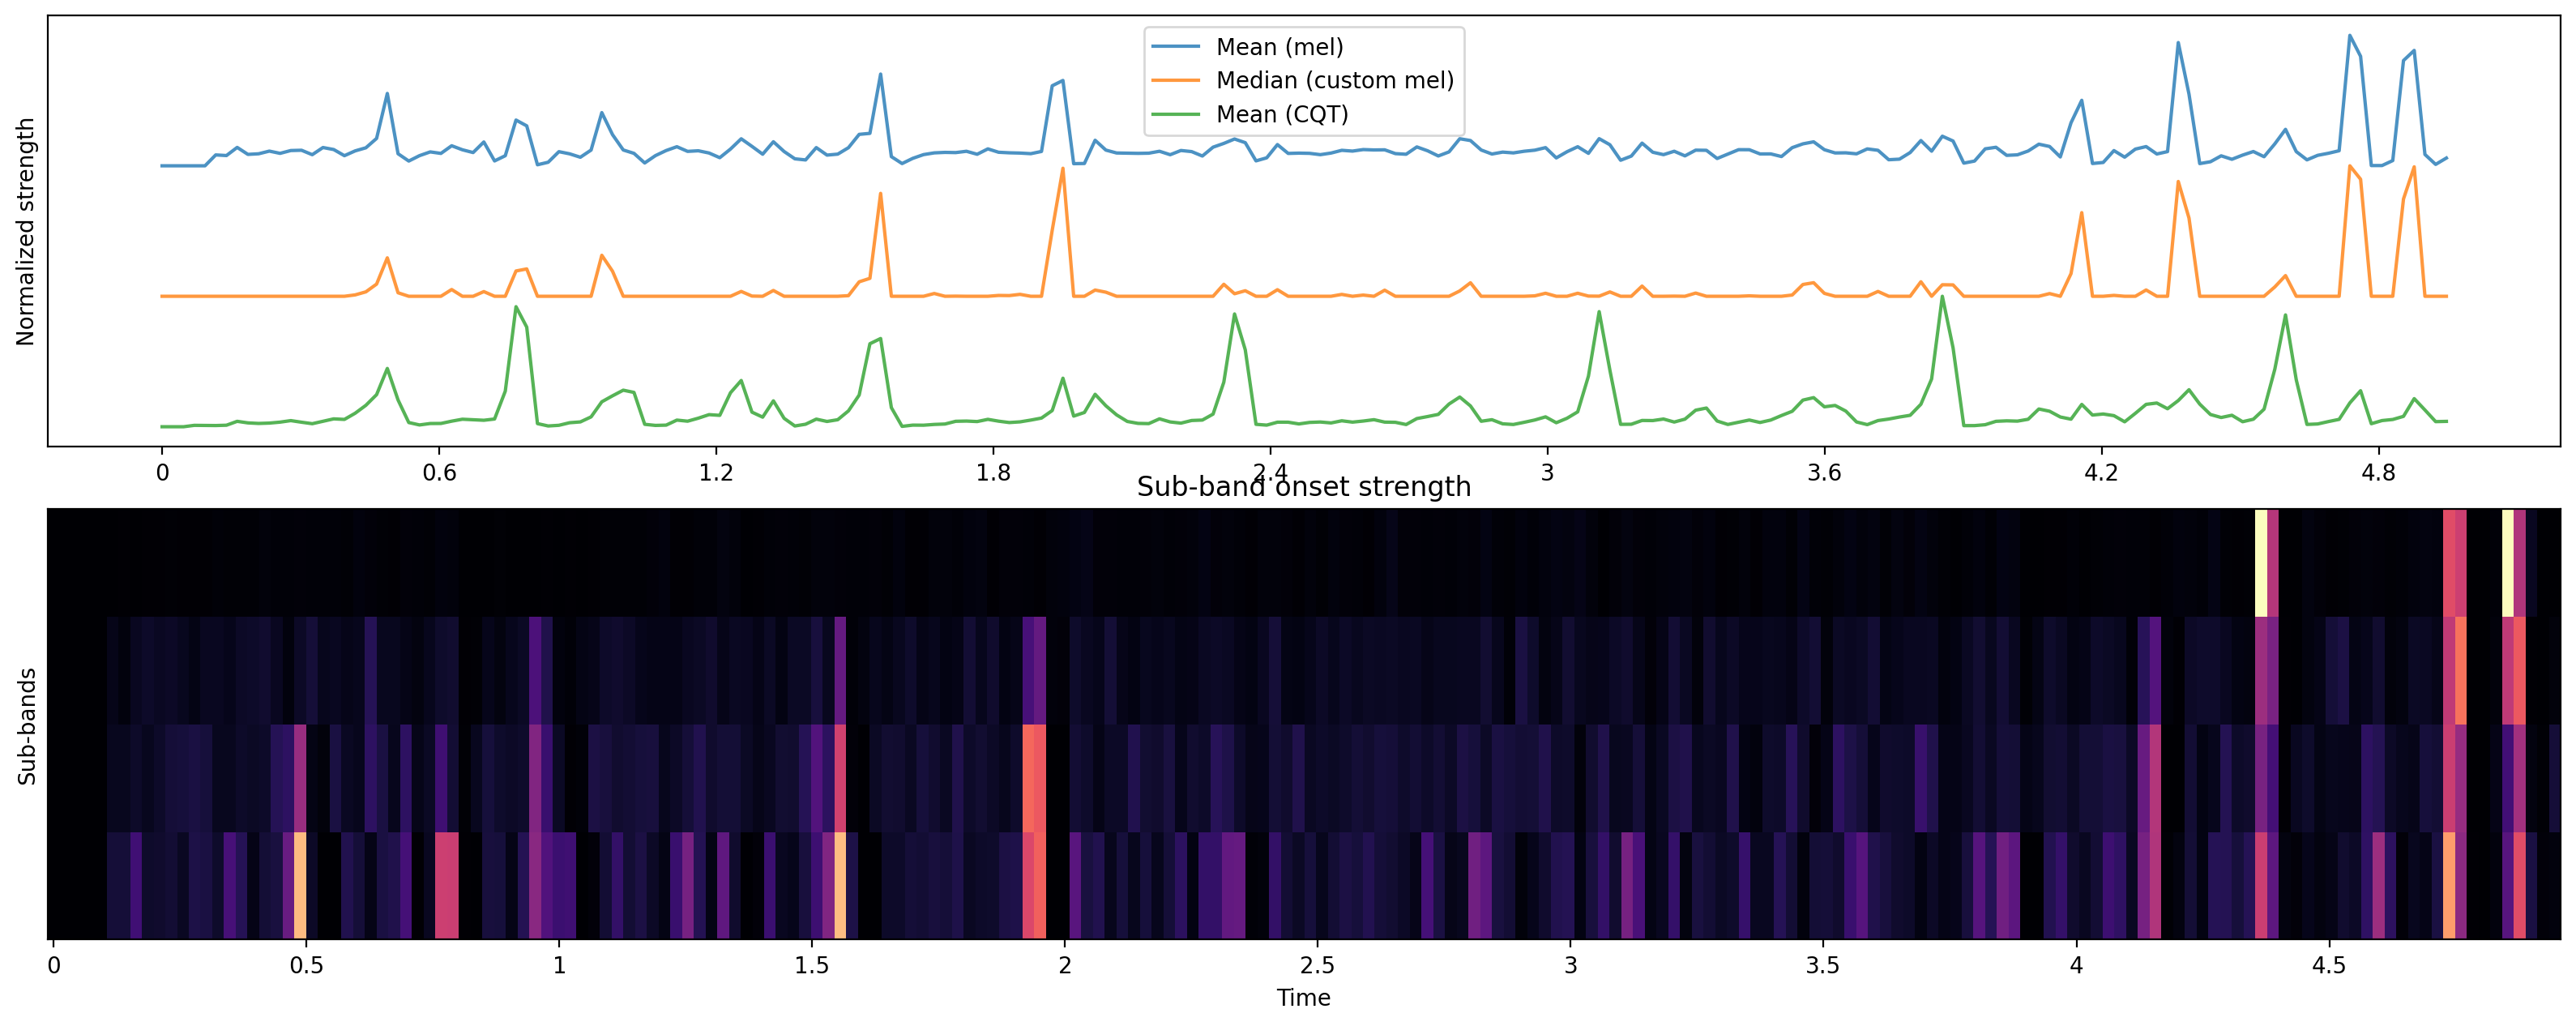

In [47]:
# Compute the short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))

plt.figure(figsize=(16, 6))

# Power spectrogram
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')

# Standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8, label='Mean (mel)')

# Median onset strength with custom mel parameters
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median, fmax=8000, n_mels=256)
plt.plot(times, 1 + (onset_env / onset_env.max()), alpha=0.8, label='Median (custom mel)')

# Constant-Q transform
C = np.abs(librosa.cqt(y, sr=sr))
onset_env_cqt = librosa.onset.onset_strength(S=C, sr=sr)
plt.plot(times, onset_env_cqt / onset_env_cqt.max(), alpha=0.8, label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

# Sub-band onset strength
onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 32, 64, 96, 128])
plt.subplot(2, 1, 2)
librosa.display.specshow(onset_subbands, x_axis='time')
plt.ylabel('Sub-bands')
plt.title('Sub-band onset strength')

plt.show()


In [48]:
print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))

Number of training examples= 832   Number of classes= 6


In [49]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast')
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast')
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)
            #normalized raw audio
            # y = audio_norm(y)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [50]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [51]:
import fnmatch
# Constants
INPUT_DIR = './heartbeat-sounds'  # Adjust according to your directory structure
MAX_SOUND_CLIP_DURATION = 5  # Specify the maximum duration of sound clips

def load_file_data(folder, file_names, duration, sr=None):
    data = []
    for sound_file in file_names:
        try:
            # Use kaiser_fast technique for faster extraction
            X, sr = librosa.load(os.path.join(folder, sound_file), sr=sr, duration=duration, res_type='kaiser_fast')
            dur = librosa.get_duration(y=X, sr=sr)
            print("Loaded file ", sound_file, " Duration:", dur, "s")

            # Ensure the loaded audio has the desired duration
            if dur < duration:
                # Pad with zeros if the audio is shorter than `duration` seconds
                pad_length = int((duration - dur) * sr)
                X = np.pad(X, (0, pad_length), mode='constant')
            elif dur > duration:
                # Truncate if the audio is longer than `duration` seconds
                X = X[:int(duration * sr)]

            # Example feature extraction (MFCCs)
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T, axis=0)
            feature = np.array(mfccs).reshape([-1, 1])
            data.append(feature)

        except Exception as e:
            print("Error encountered while parsing file: ", sound_file)
            print(e)

    return data

# Load dataset A with fixed audio length
A_folder = os.path.join(INPUT_DIR, 'set_a')
A_artifact_files = fnmatch.filter(os.listdir(A_folder), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder, file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for _ in A_artifact_sounds]

A_normal_files = fnmatch.filter(os.listdir(A_folder), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder, file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for _ in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(A_folder), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder, file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for _ in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(A_folder), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder, file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for _ in A_murmur_sounds]

A_unlabelledtest_files = fnmatch.filter(os.listdir(A_folder), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder, file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for _ in A_unlabelledtest_sounds]

print("Loaded dataset A")


Loaded file  artifact__201106041452.wav  Duration: 5.0 s
Loaded file  artifact__201106061233.wav  Duration: 5.0 s
Loaded file  artifact__201106131834.wav  Duration: 5.0 s
Loaded file  artifact__201105041959.wav  Duration: 5.0 s
Loaded file  artifact__201105280851.wav  Duration: 5.0 s
Loaded file  artifact__201106111119.wav  Duration: 5.0 s
Loaded file  artifact__201106040947.wav  Duration: 5.0 s
Loaded file  artifact__201106211430.wav  Duration: 5.0 s
Loaded file  artifact__201106212112.wav  Duration: 5.0 s
Loaded file  artifact__201106030612.wav  Duration: 5.0 s
Loaded file  artifact__201106021541.wav  Duration: 5.0 s
Loaded file  artifact__201106190520.wav  Duration: 5.0 s
Loaded file  artifact__201106121445.wav  Duration: 5.0 s
Loaded file  artifact__201106101314.wav  Duration: 5.0 s
Loaded file  artifact__201105060108.wav  Duration: 5.0 s
Loaded file  artifact__201106171003.wav  Duration: 5.0 s
Loaded file  artifact__201106101955.wav  Duration: 5.0 s
Loaded file  artifact__20110622

In [52]:
%%time
# load dataset-b, keep them separate for testing purpose
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")


Loaded file  normal__176_1307988171173_B1.wav  Duration: 1.47375 s
Loaded file  normal__173_1307973611151_C.wav  Duration: 3.0705 s
Loaded file  normal_noisynormal_139_1306519274653_D.wav  Duration: 5.0 s
Loaded file  normal__115_1306259437619_C.wav  Duration: 5.0 s
Loaded file  normal_noisynormal_154_1306935608852_C.wav  Duration: 4.64825 s
Loaded file  normal_noisynormal_136_1306429977501_C.wav  Duration: 5.0 s
Loaded file  normal__140_1306519735121_A.wav  Duration: 5.0 s
Loaded file  normal__252_1309203336604_B.wav  Duration: 1.892 s
Loaded file  normal__128_1306344005749_B.wav  Duration: 5.0 s
Loaded file  normal__140_1306519735121_D1.wav  Duration: 4.81675 s
Loaded file  normal__286_1311170606028_C.wav  Duration: 5.0 s
Loaded file  normal__202_1308145175747_C.wav  Duration: 5.0 s
Loaded file  normal__300_1311772096120_C1.wav  Duration: 5.0 s
Loaded file  normal_noisynormal_246_1309199278902_D.wav  Duration: 5.0 s
Loaded file  normal__210_1308162935880_D2.wav  Duration: 1.23325 s
L

**Conactenation**

In [53]:
#combine set-a and set-b
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds,
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


**Data Split**

In [54]:
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot Encoding

y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

**Correct Imbalanced Data**

In [55]:
# class weight

TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

**LSTM MODEL**

In [56]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

**Build Model**

In [57]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout


In [58]:
batch_size = [16, 32]
epochs = [10, 20]
optimizers = ['adam', 'rmsprop']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)
param_grid


{'batch_size': [16, 32], 'epochs': [10, 20], 'optimizer': ['adam', 'rmsprop']}

In [59]:
pip install scikeras

In [65]:
import numpy as np
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout


# Function to create the model
def create_model(optimizer='adam', learning_rate=0.0001, lstm_units=128, dense_units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(40, 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())

    model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())

    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(3, activation='softmax'))  # 3 classes for classification

    if optimizer == 'adam':
        optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimiser = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set the seed for reproducibility
tf.random.set_seed(111)

# Wrap the model with KerasClassifier
model = KerasClassifier(
    model=create_model,
    verbose=1
)

# Define the parameter grid
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learning_rate': [0.0001,0.001],
    #'model__lstm_units': [64, 128],
    #'model__dense_units': [64, 128],
    #'model__dropout_rate': [0.3, 0.4],
    #'batch_size': [8, 16],
    'epochs': [50,100]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# Example data (replace with actual data)
x_train_lstm = np.random.rand(100, 40, 1)  # Replace with actual data
y_train_lstm = np.random.randint(0, 3, 100)  # Replace with actual data
y_train_lstm = tf.keras.utils.to_categorical(y_train_lstm, 3)

# Fit the grid search
grid_result = grid.fit(x_train_lstm, y_train_lstm)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Print accuracy along with mean and std for each parameter set
for mean, stdev, param in zip(means, stds, params):
    accuracy = mean  # Assuming `mean` represents accuracy here
    print("Accuracy: %f, Mean: %f, Std: %f with params: %r" % (accuracy, mean, stdev, param))

# Use the best model
best_model = grid_result.best_estimator_.model


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.3753 - loss: 1.1028
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.3944 - loss: 1.0742
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.6152 - loss: 0.9984
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.6121 - loss: 0.9576
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.8025 - loss: 0.8110
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.8308 - loss: 0.6866
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.9230 - loss: 0.5238
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - accuracy: 0.9385 - loss: 0.3369
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.9416 - loss: 0.2758
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.9785 - loss: 0.1170
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 1.0000 - loss: 0.0666
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 1.0000 - lo

In [68]:
# Use the best model for evaluation
best_model = grid_result.best_estimator_.model_

In [69]:
# Evaluate the best model on the validation data
evaluation = best_model.evaluate(x_val_lstm, y_val_lstm)
print(f"Validation loss: {evaluation[0]}")
print(f"Validation accuracy: {evaluation[1]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.5451 - loss: 1.0603
Validation loss: 1.0629003047943115
Validation accuracy: 0.5555555820465088
